In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
NVIDIA GeForce RTX 3070 Ti


In [3]:
# bspline_smooth_price = np.load(".\\weights\\bspline_smooth_y.npy")
bspline_smooth_price = np.load(".\\weights\\diff_grade.npy")
print(bspline_smooth_price.shape)

(181, 168)


In [4]:
class BitcoinDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.astype(np.float32)).to("cuda")
        self.y = torch.from_numpy(y.astype(np.float32)).to("cuda")
        self.n_samples = x.shape[0]
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.n_samples

In [5]:
train_dataloader = DataLoader(dataset=BitcoinDataset(bspline_smooth_price, bspline_smooth_price), batch_size=32)
test_dataloader = DataLoader(dataset=BitcoinDataset(bspline_smooth_price, bspline_smooth_price))

In [6]:
for data, label in train_dataloader:
    print(type(data))
    print(data.shape, label.shape)
    print(data.size(), label.size())
    print(data.is_cuda, label.is_cuda)
    break
print(len(train_dataloader.dataset))

<class 'torch.Tensor'>
torch.Size([32, 168]) torch.Size([32, 168])
torch.Size([32, 168]) torch.Size([32, 168])
True True
181


In [7]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=168, out_features=96),
            nn.Tanh(),
            nn.Linear(in_features=96, out_features=24),
            nn.Linear(in_features=24, out_features=5),
            nn.Tanh()
        )
    def forward(self, inputs):
        inputs = inputs.view(-1, 1, 168)
        codes = self.encoder(inputs)
        return codes

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=5, out_features=24),
            nn.Tanh(),
            nn.Linear(in_features=24, out_features=96),
            nn.Linear(in_features=96, out_features=168),
            nn.Tanh()
        )
    def forward(self, inputs):
        outputs = self.decoder(inputs)
        return outputs

In [8]:
class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            Reshape(-1, 1, 1, 168),
            nn.Conv2d(1, 9, stride=1, kernel_size=(1, 7)), # 9*162
            nn.Tanh(),
            nn.Conv2d(9, 5, stride=1, kernel_size=(1, 7)), # 5*156
            nn.Tanh(),
            nn.Conv2d(5, 3, stride=1, kernel_size=(1, 7)), # 3*150
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(450, 24),
            nn.Tanh(),
            nn.Linear(24, 7),
            nn.Tanh(),
        )
    def forward(self, inputs):
        inputs = inputs.view(-1, 1, 168)
        codes = self.encoder(inputs)
        return codes

class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(7, 24),
            nn.Tanh(),
            nn.Linear(24, 450),
            nn.Tanh(),
            Reshape(-1, 3, 1, 150),
            nn.ConvTranspose2d(3, 5, stride=1, kernel_size=(1, 7)),
            nn.Tanh(),
            nn.ConvTranspose2d(5, 9, stride=1, kernel_size=(1, 7)),
            nn.Tanh(),
            nn.ConvTranspose2d(9, 1, stride=1, kernel_size=(1, 7)),
            nn.Tanh(),
            Reshape(-1, 168)
        )
    def forward(self, inputs):
        outputs = self.decoder(inputs)
        return outputs

In [9]:
class Encoder3(nn.Module):
    def __init__(self):
        super(Encoder3, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            Reshape(-1, 1, 1, 168),
            nn.Conv2d(1, 7, stride=5, kernel_size=(1, 8)), # 7*33
            nn.Tanh(),
            nn.Conv2d(7, 3, stride=2, kernel_size=(1, 3)), # 3*16
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(3*16, 7),
            nn.Tanh(),
        )
    def forward(self, inputs):
        inputs = inputs.view(-1, 1, 168)
        codes = self.encoder(inputs)
        return codes

class Decoder3(nn.Module):
    def __init__(self):
        super(Decoder3, self).__init__()
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(7, 3*16),
            nn.Tanh(),
            Reshape(-1, 3, 1, 16),
            nn.ConvTranspose2d(3, 7, stride=2, kernel_size=(1, 3)),
            nn.Tanh(),
            nn.ConvTranspose2d(7, 1, stride=5, kernel_size=(1, 8)),
            nn.Tanh(),
            Reshape(-1, 168)
        )
    def forward(self, inputs):
        outputs = self.decoder(inputs)
        return outputs

### 確認輸入輸出shape有符合

In [10]:
tmp_model = Encoder3().to(device="cuda")
tmp_encoder_output = tmp_model(torch.from_numpy(bspline_smooth_price.astype(np.float32)).to("cuda"))
print(tmp_encoder_output.shape)

torch.Size([181, 7])


In [11]:
tmp_model2 = Decoder3().to(device="cuda")
tmp_decoder_output = tmp_model2(tmp_encoder_output)
print(tmp_decoder_output.shape)

torch.Size([181, 168])


In [12]:
batch_size = 32
epochs = 50
learning_rate = 0.001

## Pytorch Lightning 子類別 Autoencoder

In [13]:
class BitcoinDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = ".\\weights\\bspline_smooth_y.npy", batch_size: int = 32):
        super(BitcoinDataModule, self).__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.data_array = np.load(self.data_dir)
        self.data_array = torch.from_numpy(self.data_array.astype(np.float32))

    def train_dataloader(self):
        return DataLoader(self.data_array, batch_size=self.batch_size)

In [14]:
class AutoEncoder_pl(pl.LightningModule):
    def __init__(self):
        super(AutoEncoder_pl, self).__init__()
        # Encoder
        self.encoder = Encoder()
        # Decoder
        self.decoder = Decoder()
    
    def forward(self, inputs):
        codes = self.encoder(inputs)
        decoded = self.decoder(codes)
        return codes, decoded # 注意! 這邊回傳tuple

    def training_step(self, batch, batch_idx):
        x, labels = batch
        # x = x.view(-1, 168)
        predictions = self.forward(x)
        loss = F.mse_loss(labels, predictions[1])
        tensorboard_logs = {'train_loss': loss}
        return {"loss": loss, 'log': tensorboard_logs}
    
    def train_dataloader(self):
        train_loader = DataLoader(dataset=BitcoinDataset(bspline_smooth_price, bspline_smooth_price),
                                  batch_size=batch_size,
                                  num_workers=0)
        return train_loader
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)

In [15]:
# bitcoindata = BitcoinDataModule()

In [16]:
# model_pl = AutoEncoder_pl()
# trainer = Trainer(auto_select_gpus=True, gpus=1, max_epochs=epochs)
# trainer.fit(model_pl)

## Pytorch 子類別 Autoencoder

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = Encoder().to(device="cuda")
        # Decoder
        self.decoder = Decoder().to(device="cuda")
    
    def forward(self, inputs):
        codes = self.encoder(inputs)
        decoded = self.decoder(codes)
        return codes, decoded # 注意! 這邊回傳tuple

class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()
        # Encoder
        self.encoder = Encoder2().to(device="cuda")
        # Decoder
        self.decoder = Decoder2().to(device="cuda")
    
    def forward(self, inputs):
        codes = self.encoder(inputs)
        decoded = self.decoder(codes)
        return codes, decoded # 注意! 這邊回傳tuple

class AutoEncoder3(nn.Module):
    def __init__(self):
        super(AutoEncoder3, self).__init__()
        # Encoder
        self.encoder = Encoder3().to(device="cuda")
        # Decoder
        self.decoder = Decoder3().to(device="cuda")
    
    def forward(self, inputs):
        codes = self.encoder(inputs)
        decoded = self.decoder(codes)
        return codes, decoded # 注意! 這邊回傳tuple

In [18]:
summary(AutoEncoder(), input_size=(32, 1, 168))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 96]          16,224
              Tanh-2                [-1, 1, 96]               0
            Linear-3                [-1, 1, 24]           2,328
            Linear-4                 [-1, 1, 5]             125
              Tanh-5                 [-1, 1, 5]               0
           Encoder-6                 [-1, 1, 5]               0
            Linear-7                [-1, 1, 24]             144
              Tanh-8                [-1, 1, 24]               0
            Linear-9                [-1, 1, 96]           2,400
           Linear-10               [-1, 1, 168]          16,296
             Tanh-11               [-1, 1, 168]               0
          Decoder-12               [-1, 1, 168]               0
Total params: 37,517
Trainable params: 37,517
Non-trainable params: 0
---------------------------------

In [19]:
def train(train_loader, model, loss_fn, optimizer, epochs, visualize=False):
    for epoch in range(1, epochs+1):
        train_loss = 0.0
        
        model.train()
        for i, (train_data, train_target) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            train_predict = model(train_data)[-1]
            t_loss = loss_fn(train_predict, train_target.reshape(train_predict.shape)) # train_predict is tuple
            t_loss.backward()
            optimizer.step()
            train_loss += t_loss.item()*train_data.shape[0]
            
            if visualize and (i == 1 or i % 10 == 0):
                # ...log the running loss
                writer.add_scalar(tag="training loss",
                                  scalar_value=train_loss/10,
                                  global_step=epoch*len(train_loader)+i)
        train_loss /= len(train_loader.dataset)
        if epoch % 10 == 0:
            print(f'running epoch: {epoch}/{epochs}')
            print(f"epoch: {epoch}, training loss = {train_loss:.4f}")

def SaveModel(path_name):
    torch.save(model.state_dict(), f".\\weights\\{path_name}") # .pth

def LoadModel(weights_path):
    loading_model = AutoEncoder().to(device="cuda")
    loading_model.load_state_dict(torch.load(weights_path)) # .pth
    return loading_model

## 全連接層 Autoencoder

In [20]:
model = AutoEncoder().to(device="cuda")
criterion = nn.MSELoss().to(device="cuda")
optimizer = torch.optim.Adam(model.parameters())

In [21]:
writer = SummaryWriter('.\\runs\\test1')
dataiter = iter(train_dataloader)
training_data, labels = dataiter.next()
writer.add_graph(model, training_data)
writer.close()

In [22]:
train(train_loader=train_dataloader, model=model, loss_fn=criterion, optimizer=optimizer, epochs=epochs, visualize=True)

running epoch: 10/50
epoch: 10, training loss = 0.0000
running epoch: 20/50
epoch: 20, training loss = 0.0000
running epoch: 30/50
epoch: 30, training loss = 0.0000
running epoch: 40/50
epoch: 40, training loss = 0.0000
running epoch: 50/50
epoch: 50, training loss = 0.0000


In [23]:
dimension_reduction_result, refactor_result = model(torch.from_numpy(bspline_smooth_price.astype(np.float32)).to("cuda"))
print(dimension_reduction_result.shape, refactor_result.shape)

torch.Size([181, 1, 5]) torch.Size([181, 1, 168])


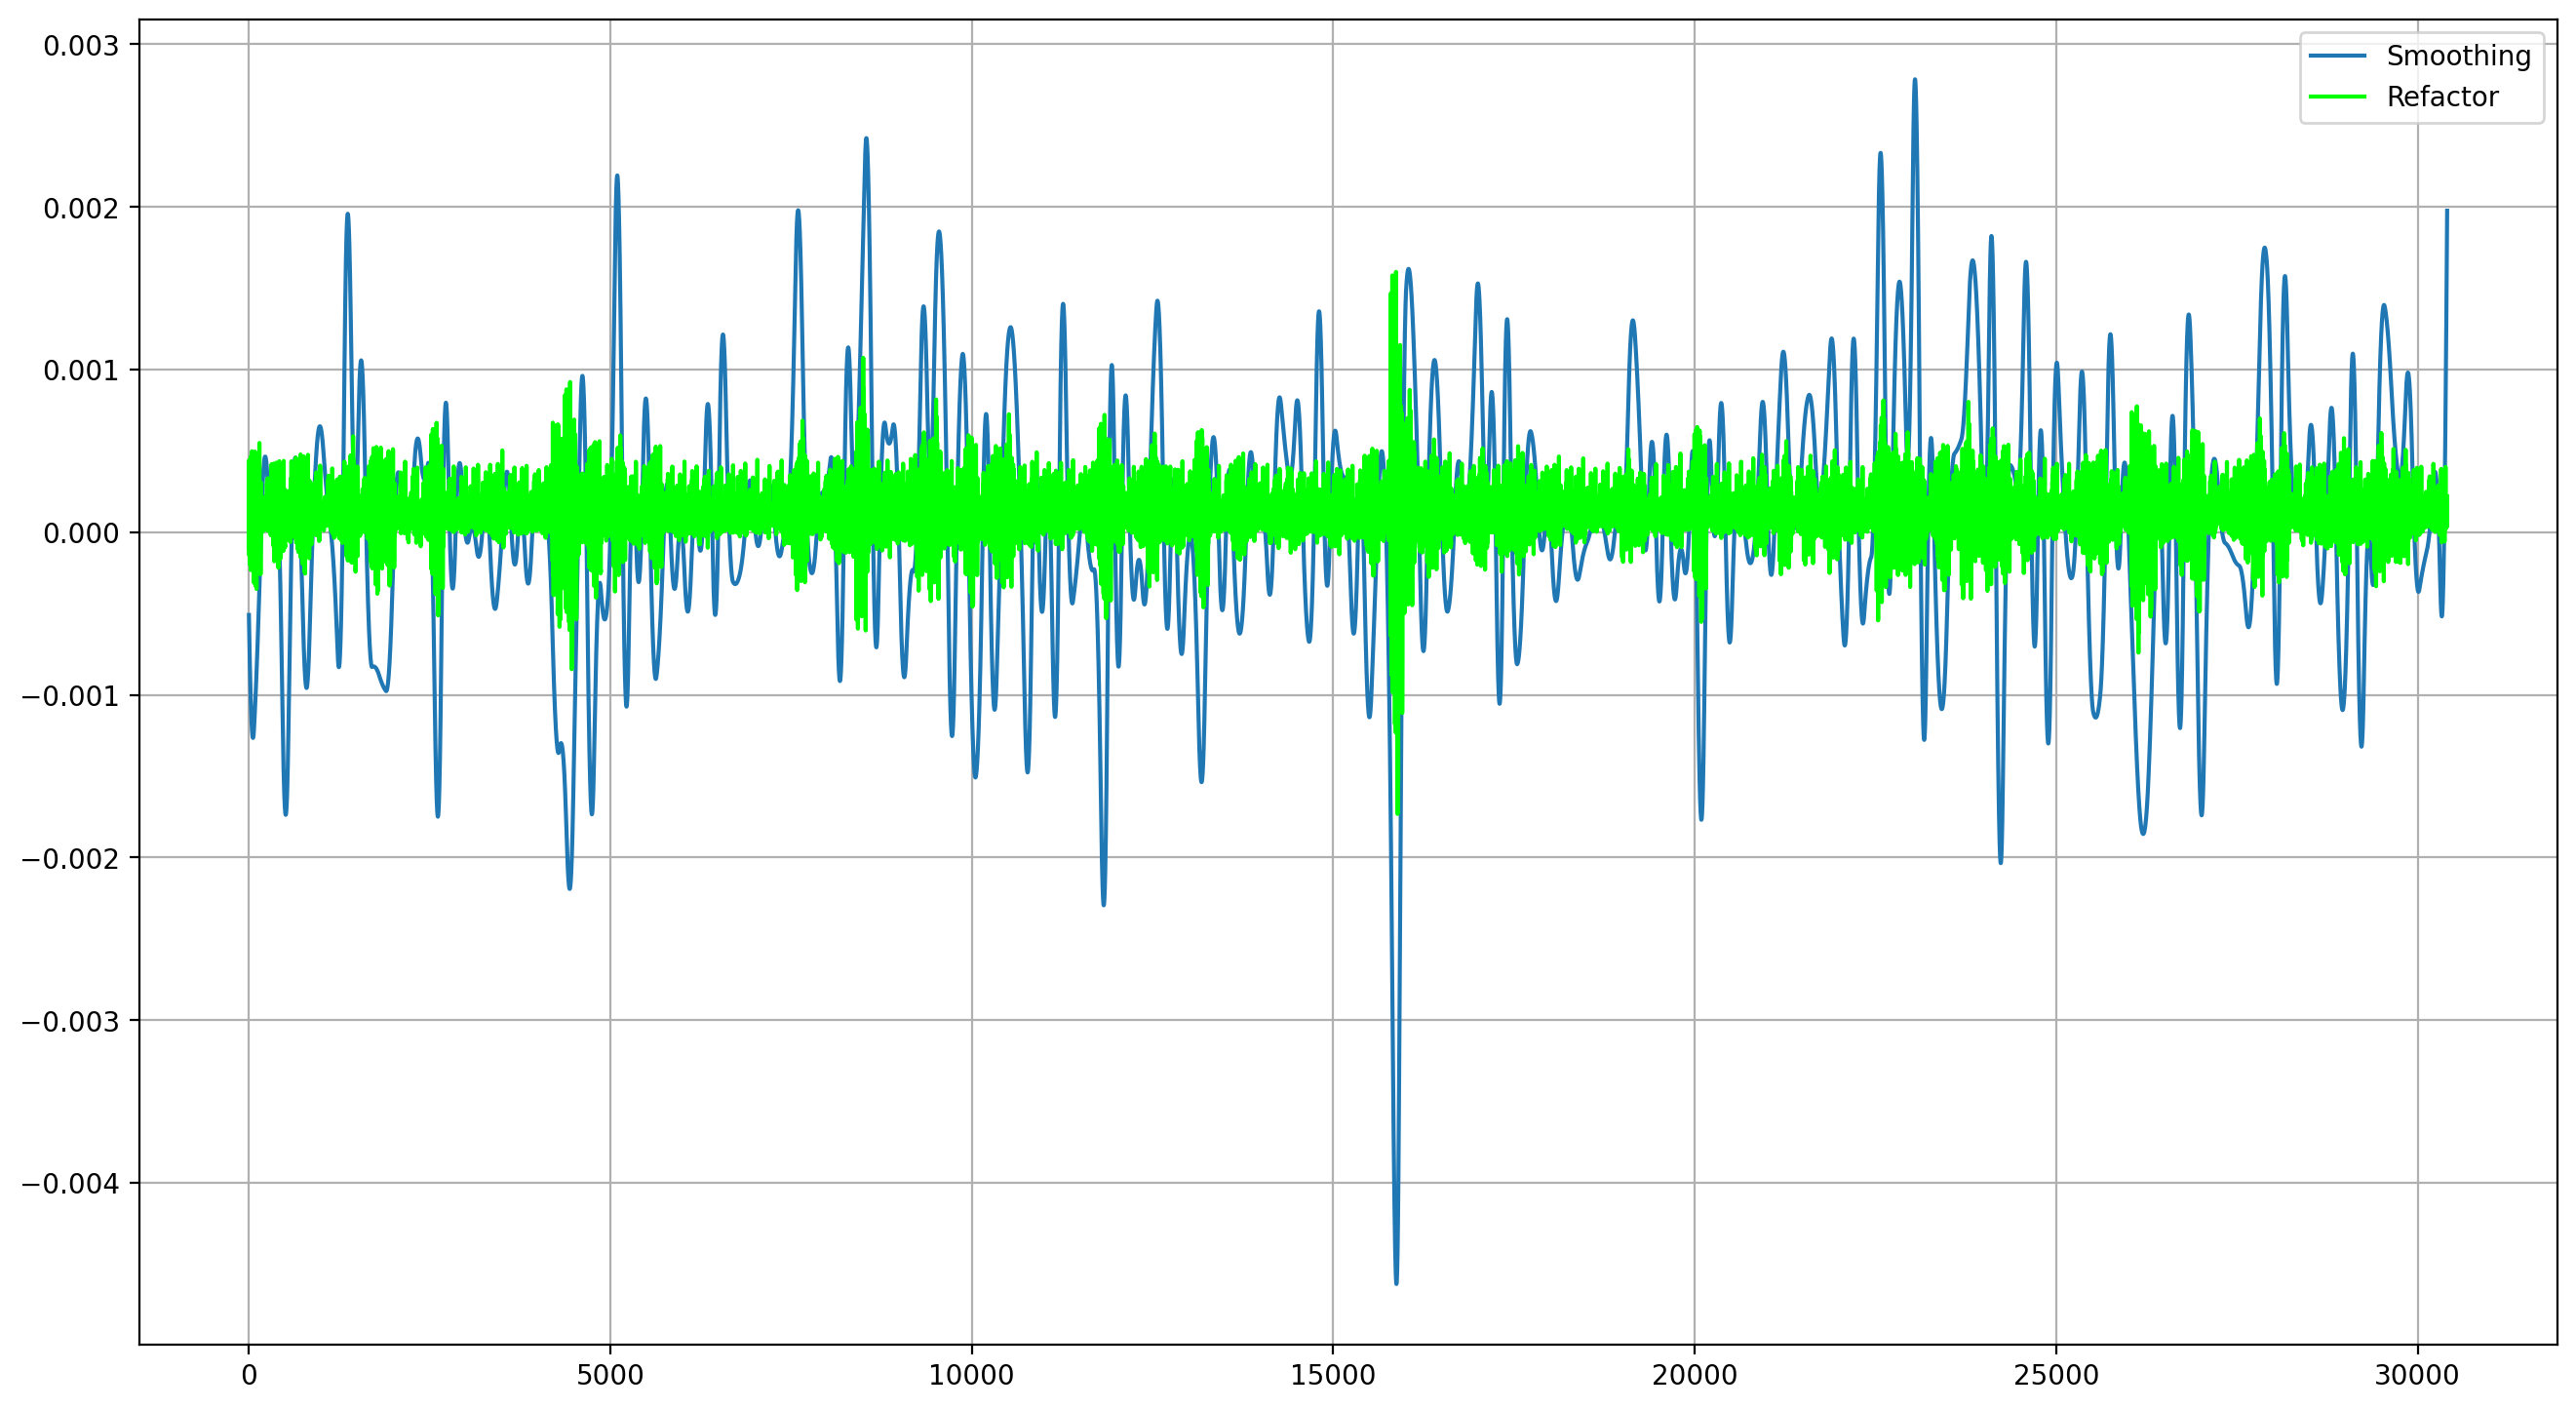

In [24]:
refactor_result_nparray = refactor_result.cpu().detach().numpy()

plt.figure(figsize=(16,9), dpi=200)
plt.plot(bspline_smooth_price.flatten(), label = 'Smoothing')
plt.plot(refactor_result_nparray.flatten(), label = 'Refactor', c="lime")
plt.legend()
plt.grid()
plt.show()

In [25]:
MAE = (np.abs(bspline_smooth_price.flatten() - refactor_result_nparray.flatten())).sum() / (bspline_smooth_price.shape[0]*bspline_smooth_price.shape[1])
print("MAE: ", MAE)

MAE:  0.0005602864964852535


In [31]:
# 降維結果
dimension_reduction_result = dimension_reduction_result.view(181, 5)
print(dimension_reduction_result.shape)
print(dimension_reduction_result[:10])
# np.save(".\\weights\\dimension_reduction_result", dimension_reduction_result.cpu().detach().numpy())

torch.Size([181, 5])
tensor([[ 0.0472, -0.0414, -0.2649,  0.0048,  0.0220],
        [ 0.0472, -0.0421, -0.2635,  0.0037,  0.0230],
        [ 0.0478, -0.0420, -0.2646,  0.0042,  0.0222],
        [ 0.0472, -0.0413, -0.2639,  0.0044,  0.0230],
        [ 0.0474, -0.0419, -0.2647,  0.0043,  0.0220],
        [ 0.0470, -0.0419, -0.2632,  0.0037,  0.0233],
        [ 0.0472, -0.0422, -0.2637,  0.0038,  0.0228],
        [ 0.0466, -0.0416, -0.2639,  0.0042,  0.0226],
        [ 0.0470, -0.0429, -0.2629,  0.0030,  0.0232],
        [ 0.0474, -0.0425, -0.2636,  0.0035,  0.0229]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [28]:
dimension_reduction_array = dimension_reduction_result.cpu().detach().numpy()
dimension_reduction_df = pd.DataFrame(dimension_reduction_array)

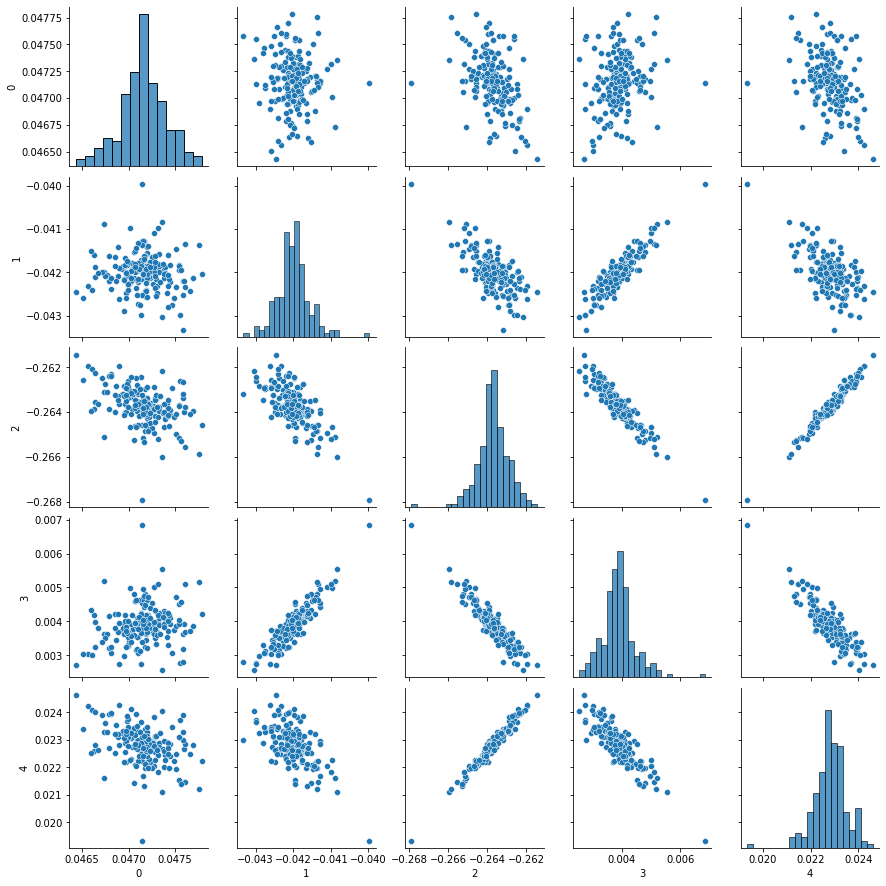

In [29]:
sns.pairplot(dimension_reduction_df)

In [30]:
px.scatter_3d(data_frame=dimension_reduction_df, x=0, y=1, z=2, color=3, size=4)

## 卷積 Autoencoder

In [ ]:
model2 = AutoEncoder2().to(device="cuda")
criterion2 = nn.MSELoss().to(device="cuda")
optimizer2 = torch.optim.Adam(model2.parameters())

In [ ]:
writer = SummaryWriter('.\\runs\\test2')
dataiter = iter(train_dataloader)
training_data, labels = dataiter.next()
writer.add_graph(model2, training_data)
writer.close()

In [ ]:
train(train_loader=train_dataloader, model=model2, loss_fn=criterion2, optimizer=optimizer2, epochs=epochs, visualize=True)

running epoch: 10/50
epoch: 10, training loss = 0.0002
running epoch: 20/50
epoch: 20, training loss = 0.0001
running epoch: 30/50
epoch: 30, training loss = 0.0000
running epoch: 40/50
epoch: 40, training loss = 0.0000
running epoch: 50/50
epoch: 50, training loss = 0.0000


In [ ]:
dimension_reduction_result2, refactor_result2 = model2(torch.from_numpy(bspline_smooth_price.astype(np.float32)).to("cuda"))
print(dimension_reduction_result2.shape, refactor_result2.shape)

torch.Size([181, 7]) torch.Size([181, 168])


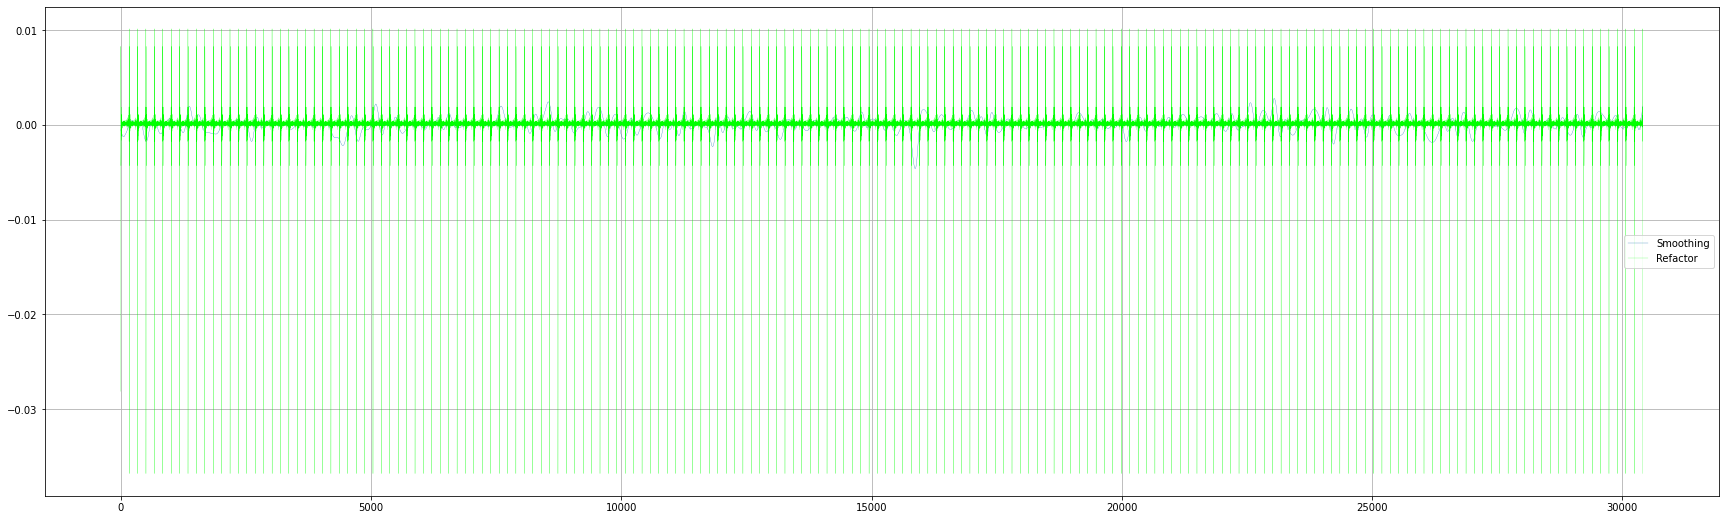

In [ ]:
refactor_result_nparray2 = refactor_result2.cpu().detach().numpy()

plt.figure(figsize=(30,9))
plt.plot(bspline_smooth_price.flatten(), label = 'Smoothing', linewidth=0.3)
plt.plot(refactor_result_nparray2.flatten(), label = 'Refactor', linewidth=0.2, c="lime")
plt.legend()
plt.grid()
plt.show()

In [ ]:
MAE2 = (np.abs(bspline_smooth_price.flatten() - refactor_result_nparray2.flatten())).sum() / (bspline_smooth_price.shape[0]*bspline_smooth_price.shape[1])
print("MAE: ", MAE2)

MAE:  0.0012543972324735029


In [ ]:
# 降維結果
print(dimension_reduction_result2.shape)
print(dimension_reduction_result2)

torch.Size([181, 7])
tensor([[-0.4131, -0.4777,  0.0140,  ..., -0.3186, -0.4732, -0.6150],
        [-0.4132, -0.4778,  0.0142,  ..., -0.3187, -0.4733, -0.6152],
        [-0.4131, -0.4777,  0.0140,  ..., -0.3186, -0.4732, -0.6150],
        ...,
        [-0.4131, -0.4777,  0.0140,  ..., -0.3186, -0.4732, -0.6150],
        [-0.4132, -0.4778,  0.0142,  ..., -0.3187, -0.4733, -0.6152],
        [-0.4132, -0.4778,  0.0142,  ..., -0.3187, -0.4732, -0.6151]],
       device='cuda:0', grad_fn=<TanhBackward0>)


## 卷積 Autoencoder2

In [ ]:
model3 = AutoEncoder3().to(device="cuda")
criterion3 = nn.MSELoss().to(device="cuda")
optimizer3 = torch.optim.Adam(model3.parameters())

In [ ]:
writer = SummaryWriter('.\\runs\\test3')
dataiter = iter(train_dataloader)
training_data, labels = dataiter.next()
writer.add_graph(model3, training_data)
writer.close()

In [ ]:
train(train_loader=train_dataloader, model=model3, loss_fn=criterion3, optimizer=optimizer3, epochs=epochs, visualize=True)

running epoch: 10/50
epoch: 10, training loss = 0.0012
running epoch: 20/50
epoch: 20, training loss = 0.0003
running epoch: 30/50
epoch: 30, training loss = 0.0002
running epoch: 40/50
epoch: 40, training loss = 0.0001
running epoch: 50/50
epoch: 50, training loss = 0.0001


In [ ]:
dimension_reduction_result3, refactor_result3 = model3(torch.from_numpy(bspline_smooth_price.astype(np.float32)).to("cuda"))
print(dimension_reduction_result3.shape, refactor_result3.shape)

torch.Size([181, 7]) torch.Size([181, 168])


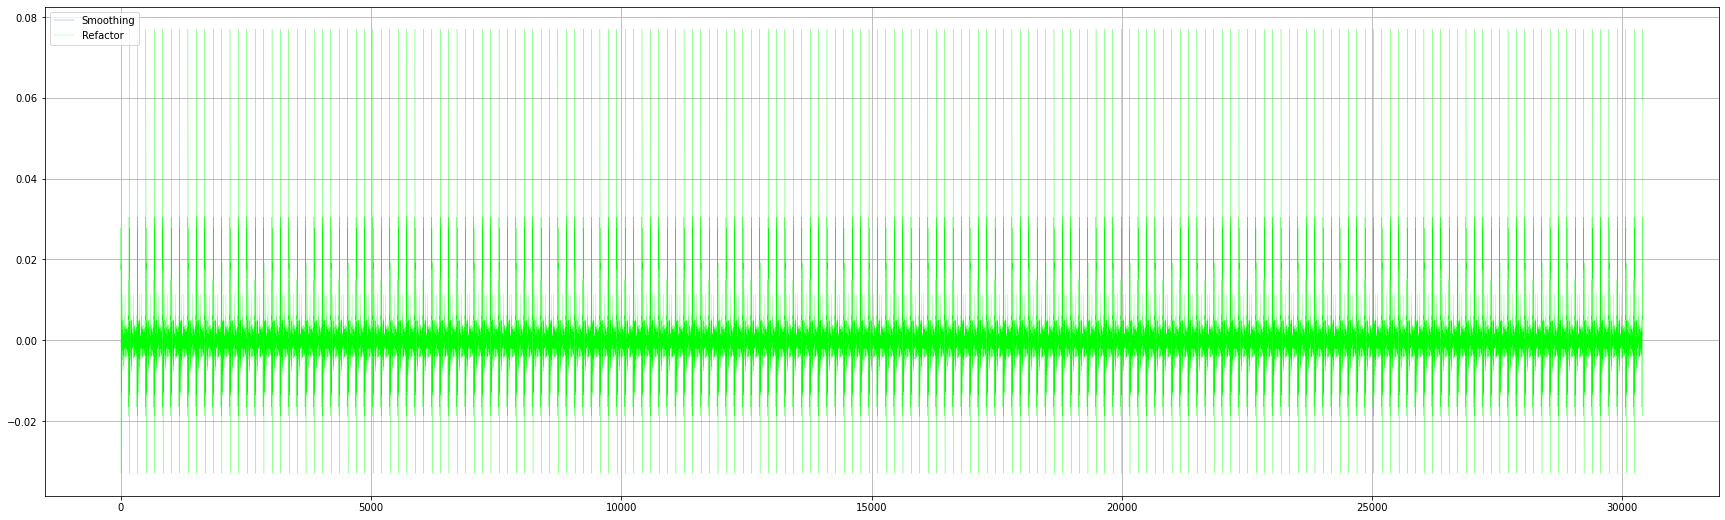

In [ ]:
refactor_result_nparray3 = refactor_result3.cpu().detach().numpy()

plt.figure(figsize=(30,9))
plt.plot(bspline_smooth_price.flatten(), label = 'Smoothing', linewidth=0.3)
plt.plot(refactor_result_nparray3.flatten(), label = 'Refactor', linewidth=0.2, c="lime")
plt.legend()
plt.grid()
plt.show()

In [ ]:
MAE3 = (np.abs(bspline_smooth_price.flatten() - refactor_result_nparray3.flatten())).sum() / (bspline_smooth_price.shape[0]*bspline_smooth_price.shape[1])
print("MAE: ", MAE3)

MAE:  0.004741195344081824


In [ ]:
print(dimension_reduction_result3.shape)
print(dimension_reduction_result3)

torch.Size([181, 7])
tensor([[-0.6199,  0.4113,  0.2951,  ..., -0.7730, -0.9239,  0.7365],
        [-0.6202,  0.4114,  0.2952,  ..., -0.7732, -0.9241,  0.7368],
        [-0.6200,  0.4114,  0.2951,  ..., -0.7730, -0.9240,  0.7367],
        ...,
        [-0.6202,  0.4114,  0.2952,  ..., -0.7731, -0.9240,  0.7367],
        [-0.6202,  0.4114,  0.2952,  ..., -0.7731, -0.9241,  0.7367],
        [-0.6202,  0.4114,  0.2953,  ..., -0.7732, -0.9241,  0.7367]],
       device='cuda:0', grad_fn=<TanhBackward0>)
